In [71]:
from utils.codification_cnn import CNNLayer, NNLayer, ChromosomeCNN, FitnessCNN
from utils.codifications import Fitness
from utils.datamanager import DataManager
from GA.parentSelector.parentSelector import RandomParentSelector, TournamentSelection, LinealOrder, WheelSelection
from GA.geneticAlgorithm import GenerationalGA
from time import time
import numpy as np

class Fitness_str(Fitness):
    def set_params(self, c, **args):
        self.c = c
        self.str = c.__repr__()
        self.time = 0
        self.max_cnn = float(c.max_layers['CNN'])
        self.max_nn = float(c.max_layers['NN'])
        self.max_filters = 256
        self.max_units = 1024
        
    def dist(self, a , b):
        return np.sqrt((a - b)**2)
        
    def comp_cnn(self, cnn_layer1, cnn_layer2):
        f = 0
        f += self.dist(cnn_layer1.filters/self.max_filters, cnn_layer2.filters/self.max_filters)
        f += 0.1 if cnn_layer1.activation!=cnn_layer2 else 0
        f += np.abs(cnn_layer1.k_size[0] - cnn_layer2.k_size[0]) / 7.
        f += np.abs(cnn_layer1.k_size[1] - cnn_layer2.k_size[1]) / 7.
        f += (cnn_layer1.maxpool != cnn_layer2.maxpool) / 2
        f += self.dist(cnn_layer1.dropout, cnn_layer2.dropout)
        return f
        
    def comp_nn(self, layer1, layer2):
        f = 0
        f += self.dist(layer1.units/self.max_units, layer2.units/self.max_units)
        f += 0.1 if layer1.activation!=layer2 else 0
        f += self.dist(layer1.dropout, layer2.dropout)
        return f
    
    def calc(self, c, test=False):
        f = 0
        f += np.abs(len(c.cnn_layers) - len(self.c.cnn_layers))
        f += np.abs(len(c.nn_layers) - len(self.c.nn_layers))
        for i in range(min(len(c.cnn_layers), len(self.c.cnn_layers))):
            f += self.comp_cnn(c.cnn_layers[i], self.c.cnn_layers[i])
        for i in range(min(len(c.nn_layers), len(self.c.nn_layers))):
            f += self.comp_nn(c.nn_layers[i], self.c.nn_layers[i])
        return f
        
    
    def calc_(self, c, test=False):
        ti = time()
        c_str = c.__repr__()
        f = max(len(self.str), len(c_str)) - min(len(self.str), len(c_str))
        for i in range(min(len(self.str), len(c_str))):
            f += self.str[i]!= c_str[i]
        self.time += time() - ti
        return f
 

mutation_rate = 0.001
mutation_rate_1 = mutation_rate * 2
ChromosomeCNN.grow_prob = mutation_rate
ChromosomeCNN.decrease_prob = mutation_rate

CNNLayer.k_prob = mutation_rate
CNNLayer.filter_prob = mutation_rate_1
CNNLayer.act_prob = mutation_rate
CNNLayer.drop_prob = mutation_rate_1
CNNLayer.maxpool_prob = mutation_rate

NNLayer.units_prob = mutation_rate_1
NNLayer.act_prob = mutation_rate
NNLayer.drop_prob = mutation_rate_1

    
fitness = Fitness_str()
l = CNNLayer(32, (3,3), 'relu', 0, False)
l2 = CNNLayer(64, (3,3), 'relu', 0.25, True)
l3 = NNLayer(128, 'relu', 0.5)
c = ChromosomeCNN([l, l2], [l3], fitness)
fitness.set_params(c)

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.25
generations = 100
population = 500
train_time = 60
maximize_fit = False
stat_val = False
folder = "../delete"
save_progress = False
age_survivors_rate = 0.1

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(population//4)}
p = ps[parents_selector_key]



generational = GenerationalGA(fitness=fitness, num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress, age_survivors_rate=age_survivors_rate)

Number of individuals eliminated by age: 0
Genetic algorithm params
Number of generations: 100
Population size: 500
num parents: 125
offspring size: 375



Creating Initial population

Start evolution process...

1) best fit: 2.649 in batch time: 0.00 mins
Current winner:
NN|U:23|A:sigmoid|D:0.946

11) best fit: 1.340 in batch time: 0.02 mins
Current winner:
CNN|F:61|K:(3,3)|A:prelu|D:0.254|M:0
CNN|F:60|K:(3,3)|A:prelu|D:0.237|M:0
NN|U:220|A:sigmoid|D:0.553

21) best fit: 0.677 in batch time: 0.03 mins
Current winner:
CNN|F:59|K:(3,3)|A:prelu|D:0.098|M:0
CNN|F:57|K:(3,3)|A:prelu|D:0.250|M:1
NN|U:220|A:prelu|D:0.556

31) best fit: 0.614 in batch time: 0.05 mins
Current winner:
CNN|F:47|K:(3,3)|A:prelu|D:0.098|M:0
CNN|F:57|K:(3,3)|A:prelu|D:0.245|M:1
NN|U:220|A:sigmoid|D:0.536

41) best fit: 0.483 in batch time: 0.07 mins
Current winner:
CNN|F:44|K:(3,3)|A:prelu|D:0.105|M:0
CNN|F:57|K:(3,3)|A:prelu|D:0.249|M:1
NN|U:130|A:sigmoid|D:0.499

51) best fit: 0.478 in batch time: 0.08 mins
Current winner:
CNN|F:44|K:(3,3)|A:prelu|D:0.097|M:0
CNN|F:56|K:(3,3)|A:prelu|D:0.247|M:1
NN|U:128|A:sigmoid|D:0.500

61) best fit: 0.478 in batch time: 0.10 min

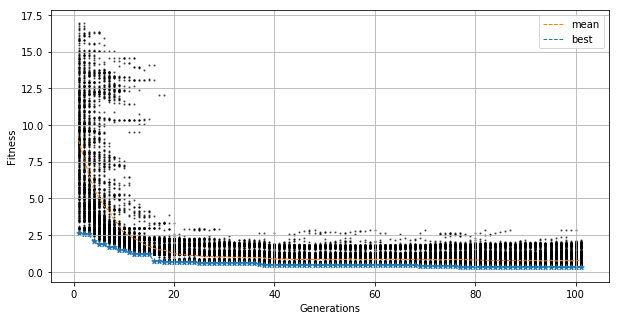

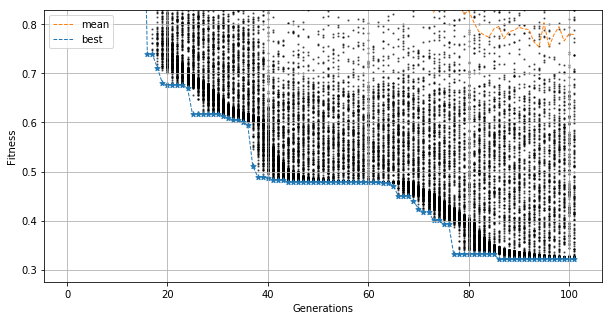

Total elapsed time: 12.729
Total training time: 0.000


In [72]:
ti_all = time()
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)